# 비트코인 가격 데이터를 가져오면서 시작 
- 언제의 가격 데이터를 가져와서 분석할지가 고민이었음 
- 2021년 테슬라의 비트코인 매입 발표 이후를 기준으로 가격 데이터를 가져옴 
  - 참고로 테슬라는 2022년 7월 발표 때 보유중인 비트코인의 75% 를 매도하였다고 밝혔으나, 프로젝트를 진행하던 4월~5월에는 알 수 없었던 내용임 

# 테슬라 매입 발표후의 가격데이터를 가져온 후 기본적인 전처리 진행 

In [ ]:
# 실시간 비트코인 가격을 가져옵니다 
# 2021년 1월 부터의 데이터로 시작; 테슬라의 비트코인 매입 발표 이후 

import requests
import pandas as pd

def get_crypto_price(symbol, exchange, start_date = None):
    api_key = 'YOUR API KEY'
    api_url = f'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol={symbol}&market={exchange}&apikey={api_key}'
    raw_df = requests.get(api_url).json()
    df = pd.DataFrame(raw_df['Time Series (Digital Currency Daily)']).T
    df = df.rename(columns = {'1a. open (USD)': 'open', '2a. high (USD)': 'high', '3a. low (USD)': 'low', '4a. close (USD)': 'close', '5. volume': 'volume'})
    for i in df.columns:
        df[i] = df[i].astype(float)
    df.index = pd.to_datetime(df.index)
    df = df.iloc[::-1].drop(['1b. open (USD)', '2b. high (USD)', '3b. low (USD)', '4b. close (USD)', '6. market cap (USD)'], axis = 1)
    if start_date:
        df = df[df.index >= start_date]
    return df

btc_0 = get_crypto_price(symbol = 'BTC', exchange = 'USD', start_date = '2021-01-31')
btc_0

# 이 데이터를 CSV로 만든 다음에 캔들스틱으로 변환하고 그 후에 아래의 절차를 따른다? 

,open,high,low,close,volume
2021-01-31,34262.89,34342.69,32171.67,33092.98,68742.280384
2021-02-01,33092.97,34717.27,32296.16,33526.37,82718.276882
2021-02-02,33517.09,35984.33,33418.00,35466.24,78056.659880
2021-02-03,35472.71,37662.63,35362.38,37618.87,80784.333663
2021-02-04,37620.26,38708.27,36161.95,36936.66,92080.735898
...,...,...,...,...,...
2022-03-18,40917.89,42325.02,40135.04,41757.51,45408.009690
2022-03-19,41757.51,42400.00,41499.29,42201.13,29067.181080
2022-03-20,42201.13,42296.26,40911.00,41262.11,30653.334680
2022-03-21,41262.11,41544.22,40467.94,41002.25,39426.248770


In [ ]:
# Stationary Data 로 만들기 
# 날짜를 index 컬럼으로 따로 처리 

btc_1 = btc_0.diff()
btc_1= btc_1.dropna()
btc_1 = btc_1.reset_index()
btc_1

,index,open,high,low,close,volume
0,2021-02-01,-1169.92,374.58,124.49,433.39,13975.996498
1,2021-02-02,424.12,1267.06,1121.84,1939.87,-4661.617002
2,2021-02-03,1955.62,1678.30,1944.38,2152.63,2727.673783
3,2021-02-04,2147.55,1045.64,799.57,-682.21,11296.402235
4,2021-02-05,-683.61,-398.15,408.05,1353.58,-25399.401623
...,...,...,...,...,...,...
410,2022-03-18,-196.12,846.20,-364.96,839.61,8218.628820
411,2022-03-19,839.62,74.98,1364.25,443.62,-16340.828610
412,2022-03-20,443.62,-103.74,-588.29,-939.02,1586.153600
413,2022-03-21,-939.02,-752.04,-443.06,-259.86,8772.914090


In [ ]:
# Stationary Data #2 
# 날짜는 원래 컬럼에 그대로 유지 

btc_2= btc_0.diff()
btc_2= btc_2.dropna()
btc_2

,open,high,low,close,volume
2021-02-01,-1169.92,374.58,124.49,433.39,13975.996498
2021-02-02,424.12,1267.06,1121.84,1939.87,-4661.617002
2021-02-03,1955.62,1678.30,1944.38,2152.63,2727.673783
2021-02-04,2147.55,1045.64,799.57,-682.21,11296.402235
2021-02-05,-683.61,-398.15,408.05,1353.58,-25399.401623
...,...,...,...,...,...
2022-03-18,-196.12,846.20,-364.96,839.61,8218.628820
2022-03-19,839.62,74.98,1364.25,443.62,-16340.828610
2022-03-20,443.62,-103.74,-588.29,-939.02,1586.153600
2022-03-21,-939.02,-752.04,-443.06,-259.86,8772.914090


In [ ]:
# 훈련/테스트 데이터셋으로 나누기 
# 80% / 20 % 비율 

from sklearn.model_selection import train_test_split 
train, test = train_test_split(btc_2, train_size = 0.80,
                               shuffle=True, random_state=121)

# Train 과 Test 데이터로 나누기 

features = ['open', 'high', 'low', 'volume']
target = ['close']

X_train = train[features]
Y_train = train[target]
X_test = test[features]
Y_test = test[target]

X_train.shape, X_test.shape

((328, 4), (82, 4))

# Model # 1 
전처리 된 Stationary Data를 이용하여 LSTM으로  모델링 진행 

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import datetime
import numpy as np

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# 스케일을 적용할 column을 정의 
scale_cols = ['open', 'high', 'low', 'close']

# 스케일 후 columns
scaled = scaler.fit_transform(btc_1[scale_cols])

btc_1 = pd.DataFrame(scaled, columns=scale_cols)
print(btc_1)

         open      high       low     close
0    0.405311  0.510473  0.643761  0.511161
1    0.513660  0.575488  0.695646  0.614218
2    0.617759  0.605446  0.738437  0.628773
3    0.630804  0.559358  0.678880  0.434843
4    0.438366  0.454181  0.658512  0.574111
..        ...       ...       ...       ...
410  0.471502  0.544829  0.618298  0.538950
411  0.541902  0.488648  0.708257  0.511861
412  0.514986  0.475628  0.606680  0.417275
413  0.421006  0.428401  0.614235  0.463736
414  0.467170  0.446083  0.658487  0.479145

[415 rows x 4 columns]


In [ ]:
# 1 Stationary 

X_train, X_test, Y_train, Y_test = train_test_split(btc_1.drop('close', 1), btc_1['close'], test_size=0.1, random_state=0, shuffle=False)
X_train.shape, Y_train.shape
print(type(X_test))
print(X_test)

<class 'pandas.core.frame.DataFrame'>
         open      high       low
373  0.498631  0.432702  0.660795
374  0.507243  0.557636  0.640202
375  0.425203  0.344702  0.573010
376  0.408588  0.421956  0.624298
377  0.474238  0.459912  0.646707
378  0.473670  0.489188  0.620666
379  0.517614  0.622252  0.682881
380  0.621381  0.468512  0.683063
381  0.439204  0.455120  0.469052
382  0.256594  0.249721  0.604863
383  0.448042  0.445628  0.647118
384  0.491950  0.459956  0.552017
385  0.369805  0.437212  0.574857
386  0.391118  0.405577  0.613874
387  0.567905  0.542989  0.673013
388  0.418199  0.526389  0.496067
389  0.558150  0.471569  0.829358
390  0.545359  0.531624  0.666355
391  0.477870  0.447290  0.555443
392  0.388472  0.801540  0.660704
393  0.856019  0.535866  0.916118
394  0.570558  0.516040  0.664550
395  0.448929  0.388565  0.559155
396  0.387022  0.368536  0.466530
397  0.260162  0.270903  0.629876
398  0.501779  0.489059  0.620688
399  0.418412  0.472528  0.588717
400  0.455

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
def windowed_dataset(x, y, window_size, batch_size, shuffle):
    # X값 window dataset 구성
    ds_x = tf.data.Dataset.from_tensor_slices(x)
    ds_x = ds_x.window(window_size, shift=1, stride=1, drop_remainder=True)
    ds_x = ds_x.flat_map(lambda x: x.batch(window_size))
    # y값 추가
    ds_y = tf.data.Dataset.from_tensor_slices(y[window_size:])
    ds = tf.data.Dataset.zip((ds_x, ds_y))
    if shuffle:
        ds = ds.shuffle(1000)
    return ds.batch(batch_size).prefetch(1)

In [ ]:
WINDOW_SIZE=5
BATCH_SIZE=32

In [ ]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(X_train, Y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(X_test, Y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [ ]:
model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=3,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 3]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [ ]:
# earlystopping은 35번 epoch통안 val_loss 개선이 없다면 학습을 멈춤 
earlystopping = EarlyStopping(monitor='val_loss', patience=35)

# val_loss 기준 체크포인터도 생성
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)
                             
history0 = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=100, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/100
     10/Unknown - 2s 6ms/step - loss: 0.1444 - mse: 0.2887
Epoch 1: val_loss improved from inf to 0.11876, saving model to tmp/ckeckpointer.ckpt
12/12 [==============================] - 3s 60ms/step - loss: 0.1413 - mse: 0.2826 - val_loss: 0.1188 - val_mse: 0.2375
Epoch 2/100
11/12 [==========================>...] - ETA: 0s - loss: 0.1047 - mse: 0.2095
Epoch 2: val_loss improved from 0.11876 to 0.07544, saving model to tmp/ckeckpointer.ckpt
12/12 [==============================] - 0s 10ms/step - loss: 0.1033 - mse: 0.2066 - val_loss: 0.0754 - val_mse: 0.1509
Epoch 3/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0619 - mse: 0.1237
Epoch 3: val_loss improved from 0.07544 to 0.03825, saving model to tmp/ckeckpointer.ckpt
12/12 [==============================] - 0s 10ms/step - loss: 0.0609 - mse: 0.1219 - val_loss: 0.0383 - val_mse: 0.0765
Epoch 4/100
10/12 [========================>.....] - ETA: 0s - loss: 0.0287 - mse: 0.0575
Epoch 4: val_loss improved from 0

In [ ]:
model.evaluate(test_data, verbose=1)

2/2 [==============================] - 0s 35ms/step - loss: 0.0067 - mse: 0.0134


[0.006689791567623615, 0.01337958313524723]

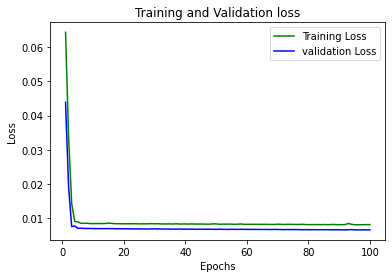

In [ ]:
# 딥러닝 평가지표 

loss_train = history0.history['loss']
loss_val = history0.history['val_loss']
epochs = range(1,101)
plt.plot(epochs, loss_train, 'g', label='Training Loss')
plt.plot(epochs, loss_val, 'b', label='validation Loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
print("%.7f" % (float(min(history.history['val_loss']))))
model.load_weights(filename)
pred = model.predict(test_data)
actual = np.asarray(Y_test)[WINDOW_SIZE:]
actual = np.reshape(actual, (len(actual), 1))
print(pred.shape)
print(actual.shape)

0.0065617
(37, 1)
(37, 1)


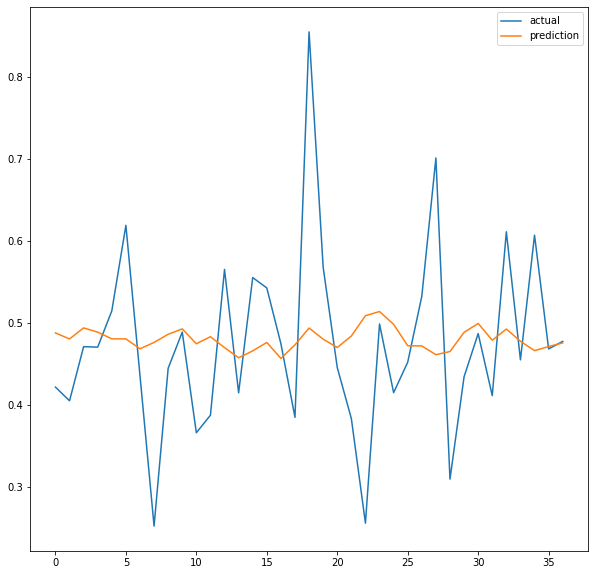

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(actual, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

# Model #2
- Close Column (일봉 기준으로) 비트코인 가격 상승 시 1로 변환, 하락 시 0으로 변환 
- 0/1 바이너리 -> 이진분류 모델링 진행 `

In [ ]:
# Stationary Data 가져오기 
btc_2

,open,high,low,close,volume
2021-02-01,-1169.92,374.58,124.49,1.0,13975.996498
2021-02-02,424.12,1267.06,1121.84,1.0,-4661.617002
2021-02-03,1955.62,1678.30,1944.38,1.0,2727.673783
2021-02-04,2147.55,1045.64,799.57,0.0,11296.402235
2021-02-05,-683.61,-398.15,408.05,1.0,-25399.401623
...,...,...,...,...,...
2022-03-16,-391.04,1830.39,730.15,1.0,42105.212410
2022-03-17,1833.68,-239.18,1671.52,0.0,-50931.380800
2022-03-18,-196.12,846.20,-364.96,1.0,8218.628820
2022-03-19,839.62,74.98,1364.25,1.0,-16340.828610


In [ ]:
# 일봉 종가가 상승으로 마감되는 경우는 1로 레이블 
# 일봉 종가가 하락으로 마감되는 경우는 0으로 레이블 

btc_2['close'].loc[btc_2['close'] >= 0] = 1
btc_2['close'].loc[btc_2['close'] <= 0] = 0
btc_2

,open,high,low,close,volume
2021-02-01,-1169.92,374.58,124.49,1.0,13975.996498
2021-02-02,424.12,1267.06,1121.84,1.0,-4661.617002
2021-02-03,1955.62,1678.30,1944.38,1.0,2727.673783
2021-02-04,2147.55,1045.64,799.57,0.0,11296.402235
2021-02-05,-683.61,-398.15,408.05,1.0,-25399.401623
...,...,...,...,...,...
2022-03-18,-196.12,846.20,-364.96,1.0,8218.628820
2022-03-19,839.62,74.98,1364.25,1.0,-16340.828610
2022-03-20,443.62,-103.74,-588.29,0.0,1586.153600
2022-03-21,-939.02,-752.04,-443.06,0.0,8772.914090


In [ ]:
from keras import models
from keras import layers

#// Keras에서 모델을 빌드하는 방법은 Sequential()과 함수형 API 두 방법이 있다.
model3 = models.Sequential() 
model3.add(layers.Dense(16, activation='relu', input_shape(10000,)))
model3.add(layers.Dense(16, activation='relu'))
model3.add(layers.Dense(1, activation='sigmoid'))

SyntaxError: ignored

In [ ]:
# 1 Stationary 
from sklearn.model_selection import train_test_split 
X_train3, X_test3, Y_train3, Y_test3 = train_test_split(btc_2.drop('close', 1), btc_2['close'], test_size=0.1, random_state=0, shuffle=False)
X_train3.shape, Y_train3.shape
print(type(X_test3))
print(X_test3)

<class 'pandas.core.frame.DataFrame'>
               open     high      low       volume
2022-02-09   203.01  -693.00   451.92 -30452.12658
2022-02-10   329.71  1022.00    56.09  27929.12362
2022-02-11  -877.27 -1901.00 -1235.50 -17382.12221
2022-02-12 -1121.71  -840.51  -249.63 -18418.31189
2022-02-13  -155.86  -319.49   181.12  -8824.77568
2022-02-14  -164.22    82.40  -319.44  16278.04947
2022-02-15   482.29  1909.00   876.47   4085.06516
2022-02-16  2008.91  -201.43   879.97  -9623.32306
2022-02-17  -671.29  -385.26 -3233.79  18774.12224
2022-02-18 -3357.85 -3204.83  -623.21  -3400.07253
2022-02-19  -541.26  -515.56   189.03 -25803.86731
2022-02-20   104.72  -318.88 -1639.03  15397.23501
2022-02-21 -1692.28  -631.09 -1200.00  28908.39485
2022-02-22 -1378.73 -1065.35  -450.00  -8561.73907
2022-02-23  1222.17   820.93   686.79 -10225.21389
2022-02-24  -980.31   593.07 -2714.51  76915.56258
2022-02-25  1078.66  -159.47  3692.09 -63901.72333
2022-02-26   890.48   664.92   558.81 -27213

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
WINDOW_SIZE=5
BATCH_SIZE=32

In [ ]:
def windowed_dataset(x, y, window_size, batch_size, shuffle):
    # X값 window dataset 구성
    ds_x = tf.data.Dataset.from_tensor_slices(x)
    ds_x = ds_x.window(window_size, shift=1, stride=1, drop_remainder=True)
    ds_x = ds_x.flat_map(lambda x: x.batch(window_size))
    # y값 추가
    ds_y = tf.data.Dataset.from_tensor_slices(y[window_size:])
    ds = tf.data.Dataset.zip((ds_x, ds_y))
    if shuffle:
        ds = ds.shuffle(1000)
    return ds.batch(batch_size).prefetch(1)

In [ ]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data3 = windowed_dataset(X_train3, Y_train3, WINDOW_SIZE, BATCH_SIZE, True)
test_data3 = windowed_dataset(X_test3, Y_test3, WINDOW_SIZE, BATCH_SIZE, False)

In [ ]:
model3 = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=4,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 4]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model3.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [ ]:
# earlystopping은 35번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=35)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)
                             
history = model3.fit(train_data3, 
                    validation_data=(test_data3), 
                    epochs=100, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/100
      7/Unknown - 0s 9ms/step - loss: 0.1248 - mse: 0.2495 
Epoch 1: val_loss improved from inf to 0.13275, saving model to tmp/ckeckpointer.ckpt
12/12 [==============================] - 0s 21ms/step - loss: 0.1303 - mse: 0.2605 - val_loss: 0.1327 - val_mse: 0.2655
Epoch 2/100
 9/12 [=====================>........] - ETA: 0s - loss: 0.1292 - mse: 0.2584
Epoch 2: val_loss did not improve from 0.13275
12/12 [==============================] - 0s 10ms/step - loss: 0.1289 - mse: 0.2578 - val_loss: 0.1388 - val_mse: 0.2775
Epoch 3/100
11/12 [==========================>...] - ETA: 0s - loss: 0.1276 - mse: 0.2552
Epoch 3: val_loss did not improve from 0.13275
12/12 [==============================] - 0s 9ms/step - loss: 0.1290 - mse: 0.2580 - val_loss: 0.1419 - val_mse: 0.2839
Epoch 4/100
 9/12 [=====================>........] - ETA: 0s - loss: 0.1292 - mse: 0.2584
Epoch 4: val_loss did not improve from 0.13275
12/12 [==============================] - 0s 10ms/step - loss: 0.1292 - m

In [ ]:
print("%.7f" % (float(min(history.history['val_loss']))))
model3.load_weights(filename)
pred0 = model3.predict(test_data3)
actual0 = np.asarray(Y_test3)[WINDOW_SIZE:]
actual0 = np.reshape(actual0, (len(actual0), 1))
print(pred0.shape)
print(actual0.shape)

0.1327479
(37, 1)
(37, 1)


In [ ]:
pred0

array([[0.711394  ],
       [0.15249208],
       [0.19043848],
       [0.45528254],
       [0.00570159],
       [0.2778688 ],
       [0.68396866],
       [0.9935881 ],
       [0.42278013],
       [0.6482921 ],
       [0.6554914 ],
       [0.36053503],
       [0.28124994],
       [0.01781154],
       [0.60044694],
       [0.3588112 ],
       [0.3208241 ],
       [0.43922907],
       [0.5163677 ],
       [0.41699043],
       [0.32940233],
       [0.7704043 ],
       [0.49461097],
       [0.11755445],
       [0.611439  ],
       [0.51658076],
       [0.56615084],
       [0.5894922 ],
       [0.4604048 ],
       [0.3588112 ],
       [0.35289654],
       [0.38332227],
       [0.18239605],
       [0.14601591],
       [0.69959784],
       [0.35723805],
       [0.33334014]], dtype=float32)

In [ ]:
pred2 = np.where(pred0>=0.5,1,0)
pred2

array([[1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0]])

In [ ]:
actual0

array([[0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.]])

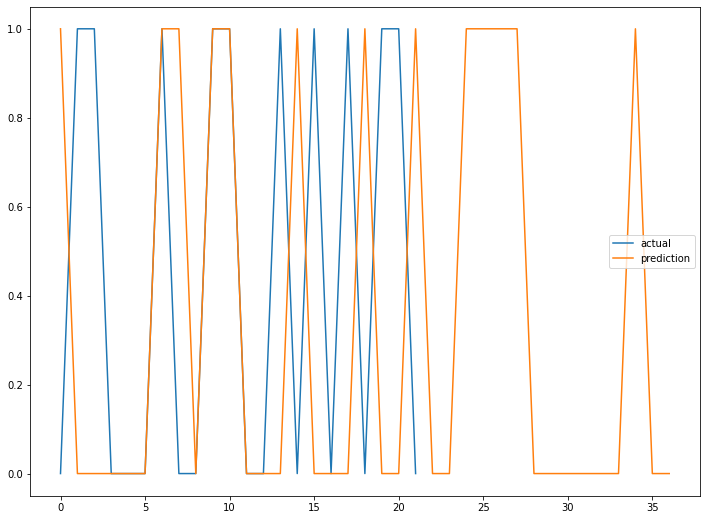

In [ ]:
# Pred #2 
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(Y_test3)[20:], label='actual')
plt.plot(pred2, label='prediction')
plt.legend()
plt.show()

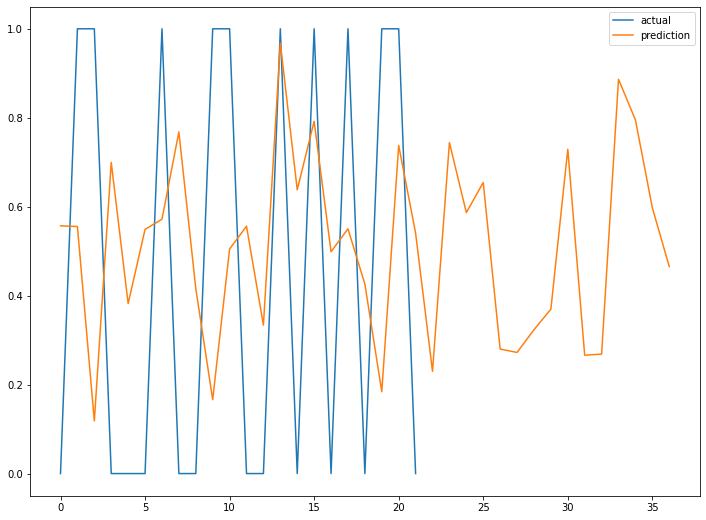

In [ ]:
# Pred #1 
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(Y_test3)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

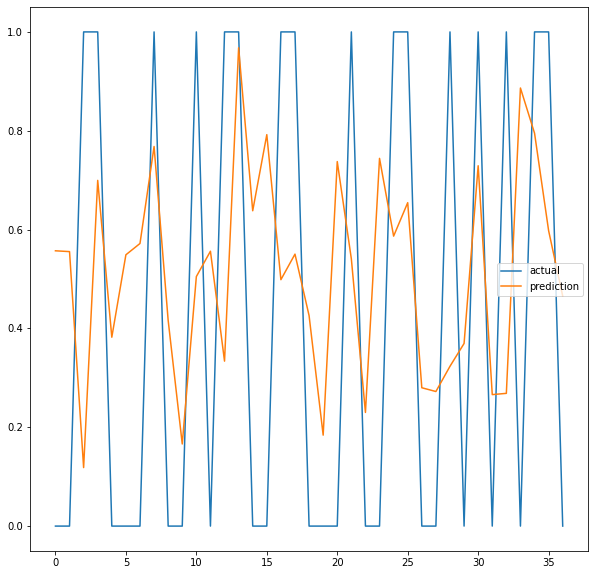

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(actual, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

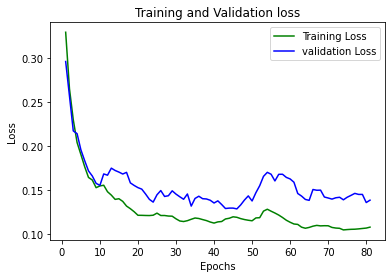

In [ ]:
# 딥러닝 평가지표 

loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,82)
plt.plot(epochs, loss_train, 'g', label='Training Loss')
plt.plot(epochs, loss_val, 'b', label='validation Loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Loss Function을 'binary_crossentropy' 로 바꾸면? 
- 이전에는 Huber을 사용하였음 

In [ ]:
model4 = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=4,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 4]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model4.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['mse'])

In [ ]:
import keras

In [ ]:
# 파라미터 저장 경로를 설정하는 코드입니다.
checkpoint_filepath = "FMbest.hdf5"

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

In [ ]:
save_best = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch', options=None)

In [ ]:
model.evaluate(test_data3, verbose=1)

ValueError: ignored

In [ ]:
model4.evaluate(test_data3, verbose=1)

2/2 [==============================] - 0s 35ms/step - loss: 0.7913 - mse: 0.2917


[0.7912996411323547, 0.291693776845932]

In [ ]:
model4.fit(X_train3, Y_train3, batch_size=32, epochs=30, verbose=1, 
          validation_data=(X_test3, Y_test3), 
          callbacks=[early_stop, save_best])

Epoch 1/30


ValueError: ignored

In [ ]:
# earlystopping은 35번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=35)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)
                             
history = model4.fit(train_data3, 
                    validation_data=(test_data3), 
                    epochs=100, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/100
      1/Unknown - 3s 3s/step - loss: 10.2159 - mse: 1.4653
Epoch 1: val_loss improved from inf to 6.03666, saving model to tmp/ckeckpointer.ckpt
12/12 [==============================] - 4s 66ms/step - loss: 7.2797 - mse: 0.9689 - val_loss: 6.0367 - val_mse: 0.7432
Epoch 2/100
 1/12 [=>............................] - ETA: 0s - loss: 6.4057 - mse: 0.7824
Epoch 2: val_loss improved from 6.03666 to 6.00300, saving model to tmp/ckeckpointer.ckpt
12/12 [==============================] - 0s 9ms/step - loss: 7.2201 - mse: 0.9560 - val_loss: 6.0030 - val_mse: 0.7246
Epoch 3/100
12/12 [==============================] - ETA: 0s - loss: 7.1821 - mse: 0.9276
Epoch 3: val_loss improved from 6.00300 to 5.98994, saving model to tmp/ckeckpointer.ckpt
12/12 [==============================] - 0s 11ms/step - loss: 7.1821 - mse: 0.9276 - val_loss: 5.9899 - val_mse: 0.6808
Epoch 4/100
11/12 [==========================>...] - ETA: 0s - loss: 7.0876 - mse: 0.8923
Epoch 4: val_loss did not improve 

In [ ]:
print("%.7f" % (float(min(history.history['val_loss']))))
model4.load_weights(filename)
pred = model4.predict(test_data3)
actual = np.asarray(Y_test3)[WINDOW_SIZE:]
actual = np.reshape(actual, (len(actual), 1))
print(pred.shape)
print(actual.shape)

0.7912996
(37, 1)
(37, 1)


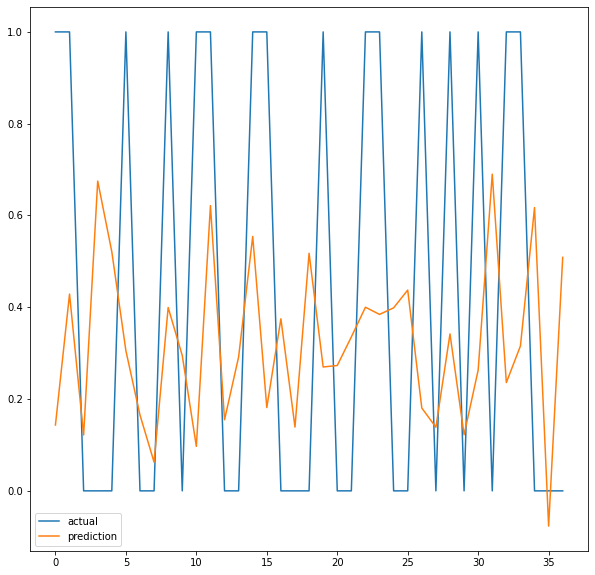

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(actual, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

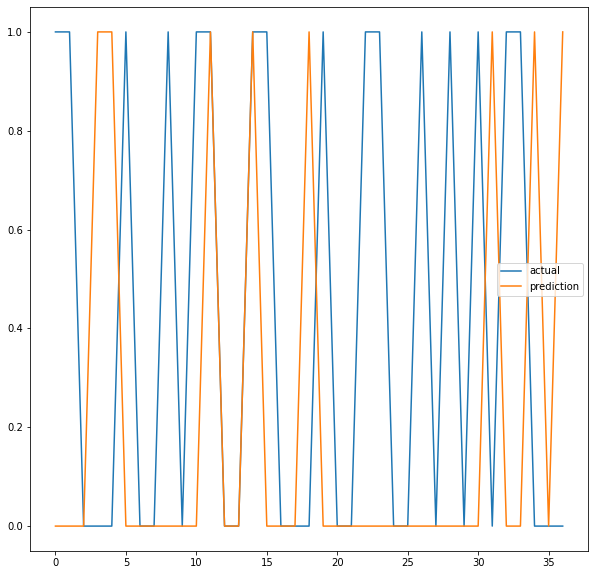

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(actual, label='actual')
plt.plot(pred2, label='prediction')
plt.legend()
plt.show()

In [ ]:
pred2 = np.where(pred>=0.5,1,0)
pred2

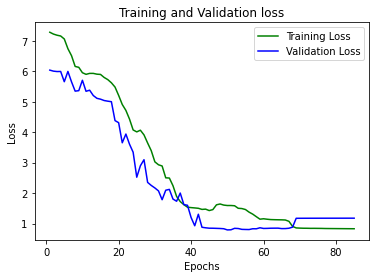

In [ ]:
# 딥러닝 평가지표 
# Trainig and Validation Loss 

loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,86)
plt.plot(epochs, loss_train, 'g', label='Training Loss')
plt.plot(epochs, loss_val, 'b', label='Validation Loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
Y_train3

2021-02-01    1.0
2021-02-02    1.0
2021-02-03    1.0
2021-02-04    0.0
2021-02-05    1.0
             ... 
2022-02-02    0.0
2022-02-03    1.0
2022-02-04    1.0
2022-02-05    0.0
2022-02-06    1.0
Name: close, Length: 371, dtype: float64

# 모델 #4 
# 간단한 이진분류 모델로 만들어보기 

In [ ]:
model5 = Sequential()
model5.add(Dense(12, input_dim=4, activation='relu'))
model5.add(Dense(4, activation='relu'))
model5.add(Dense(1, activation='sigmoid'))

In [ ]:
model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
Y_train3

In [ ]:
history5 = model5.fit(X_train3, Y_train3, epochs=100, batch_size=10)


Epoch 1/100
38/38 [==============================] - 0s 2ms/step - loss: 1.1351 - accuracy: 0.7224
Epoch 2/100
38/38 [==============================] - 0s 2ms/step - loss: 1.2950 - accuracy: 0.7089
Epoch 3/100
38/38 [==============================] - 0s 2ms/step - loss: 1.1626 - accuracy: 0.7224
Epoch 4/100
38/38 [==============================] - 0s 2ms/step - loss: 1.0849 - accuracy: 0.7089
Epoch 5/100
38/38 [==============================] - 0s 2ms/step - loss: 2.2066 - accuracy: 0.7008
Epoch 6/100
38/38 [==============================] - 0s 2ms/step - loss: 1.3969 - accuracy: 0.7170
Epoch 7/100
38/38 [==============================] - 0s 2ms/step - loss: 1.4270 - accuracy: 0.7170
Epoch 8/100
38/38 [==============================] - 0s 2ms/step - loss: 0.9556 - accuracy: 0.7305
Epoch 9/100
38/38 [==============================] - 0s 2ms/step - loss: 1.0308 - accuracy: 0.7278
Epoch 10/100
38/38 [==============================] - 0s 2ms/step - loss: 1.1325 - accuracy: 0.7143
Epoch 11/

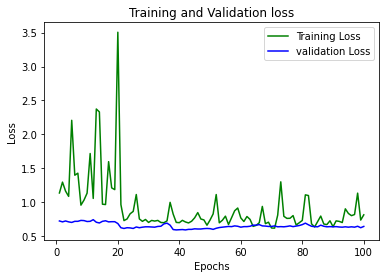

In [ ]:
# 딥러닝 평가지표 
# Trainig and Validation Loss 

loss_train = history5.history['loss']
loss_val = history5.history['accuracy']
epochs = range(1,101)
plt.plot(epochs, loss_train, 'g', label='Training Loss')
plt.plot(epochs, loss_val, 'b', label='validation Loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# earlystopping은 35번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=35)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)
                             
history5 = model5.fit(X_train3, 
                    validation_data=(Y_train3), 
                    epochs=100, 
                    callbacks=[checkpoint, earlystopping])

ValueError: ignored

In [ ]:
print("%.7f" % (float(min(history.history['val_loss']))))
model5.load_weights(filename)
pred = model4.predict(test_data3)
actual = np.asarray(Y_test3)[WINDOW_SIZE:]
actual = np.reshape(actual, (len(actual), 1))
print(pred.shape)
print(actual.shape)

In [ ]:
pred3 = model5.predict(X_test3)
pred3

array([[1.0000000e+00],
       [9.9999368e-01],
       [6.0447937e-01],
       [1.0000000e+00],
       [6.0447937e-01],
       [6.0447937e-01],
       [6.0447937e-01],
       [9.9951947e-01],
       [6.0447937e-01],
       [6.0447937e-01],
       [7.0221070e-13],
       [1.0000000e+00],
       [6.0447937e-01],
       [4.3512472e-08],
       [9.9999976e-01],
       [6.0447937e-01],
       [6.0447937e-01],
       [1.0000000e+00],
       [6.0447937e-01],
       [6.0447937e-01],
       [7.6297283e-07],
       [1.0000000e+00],
       [6.0447937e-01],
       [6.0447937e-01],
       [6.0447937e-01],
       [6.1241770e-15],
       [6.0447937e-01],
       [2.4308488e-01],
       [9.9999154e-01],
       [6.0447937e-01],
       [6.0447937e-01],
       [1.3432831e-22],
       [6.0447937e-01],
       [6.0447937e-01],
       [8.4310523e-06],
       [1.0000000e+00],
       [0.0000000e+00],
       [1.0000000e+00],
       [6.0447937e-01],
       [9.9982899e-01],
       [6.0447937e-01],
       [6.044793

In [ ]:
pred3 = np.where(pred3>=0.5,1,0)
pred3

In [ ]:
pred = model5.predict(Y_test3)


ValueError: ignored

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['open', 'high', 'low', 'close', 'volume']
# 스케일 후 columns
scaled = scaler.fit_transform(btc_2[scale_cols])

btc_10 = pd.DataFrame(scaled, columns=scale_cols)
print(btc_10)

         open      high       low  close    volume
0    0.405311  0.510473  0.643761    1.0  0.425281
1    0.513660  0.575488  0.695646    1.0  0.377333
2    0.617759  0.605446  0.738437    1.0  0.396343
3    0.630804  0.559358  0.678880    0.0  0.418388
4    0.438366  0.454181  0.658512    1.0  0.323980
..        ...       ...       ...    ...       ...
408  0.458253  0.616525  0.675269    1.0  0.497649
409  0.609470  0.465762  0.724242    0.0  0.258294
410  0.471502  0.544829  0.618298    1.0  0.410470
411  0.541902  0.488648  0.708257    1.0  0.347285
412  0.514986  0.475628  0.659541    0.0  0.317405

[413 rows x 5 columns]


In [ ]:
# 레이블링 해서 시도하기? 
btc_2.loc[btc_2['close'] >= 0] = 1

,open,high,low,close,volume
2021-02-01,-1169.92,374.58,124.49,433.39,13975.996498
2021-02-02,424.12,1267.06,1121.84,1939.87,-4661.617002
2021-02-03,1955.62,1678.30,1944.38,2152.63,2727.673783
2021-02-04,2147.55,1045.64,799.57,-682.21,11296.402235
2021-02-05,-683.61,-398.15,408.05,1353.58,-25399.401623
...,...,...,...,...,...
2022-03-14,-1030.00,637.12,-23.51,1894.03,14153.630160
2022-03-15,1894.02,-59.51,543.33,-391.04,-929.904490
2022-03-16,-391.04,1830.39,730.15,1833.67,42105.212410
2022-03-17,1833.68,-239.18,1671.52,-196.10,-50931.380800


In [ ]:
btc1 = btc.drop('index', axis=1)
btc1

In [ ]:
# 2 Non-Stationary 
X_train, X_test, Y_train, Y_test = train_test_split(btc_1_.drop('close', 1), btc_1_['close'], test_size=0.1, random_state=0, shuffle=False)
X_train.shape, Y_train.shape
print(type(X_test))
print(X_test)

In [ ]:
def windowed_dataset(x, y, window_size, batch_size, shuffle):
    # X값 window dataset 구성
    ds_x = tf.data.Dataset.from_tensor_slices(x)
    ds_x = ds_x.window(window_size, shift=1, stride=1, drop_remainder=True)
    ds_x = ds_x.flat_map(lambda x: x.batch(window_size))
    # y값 추가
    ds_y = tf.data.Dataset.from_tensor_slices(y[window_size:])
    ds = tf.data.Dataset.zip((ds_x, ds_y))
    if shuffle:
        ds = ds.shuffle(1000)
    return ds.batch(batch_size).prefetch(1)

In [ ]:
WINDOW_SIZE=5
BATCH_SIZE=32

In [ ]:
Y_train

In [ ]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(X_train, Y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(X_test, Y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [ ]:
model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=3,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 3]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [ ]:
# earlystopping은 35번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=35)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)
                             
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=1000, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/1000
      1/Unknown - 2s 2s/step - loss: 0.1800 - mse: 0.3602
Epoch 1: val_loss improved from inf to 0.09928, saving model to tmp/ckeckpointer.ckpt
12/12 [==============================] - 3s 50ms/step - loss: 0.1327 - mse: 0.2655 - val_loss: 0.0993 - val_mse: 0.1986
Epoch 2/1000
 1/12 [=>............................] - ETA: 0s - loss: 0.1205 - mse: 0.2410
Epoch 2: val_loss improved from 0.09928 to 0.05562, saving model to tmp/ckeckpointer.ckpt
12/12 [==============================] - 0s 8ms/step - loss: 0.0840 - mse: 0.1681 - val_loss: 0.0556 - val_mse: 0.1112
Epoch 3/1000
 1/12 [=>............................] - ETA: 0s - loss: 0.0569 - mse: 0.1139
Epoch 3: val_loss improved from 0.05562 to 0.02310, saving model to tmp/ckeckpointer.ckpt
12/12 [==============================] - 0s 7ms/step - loss: 0.0434 - mse: 0.0868 - val_loss: 0.0231 - val_mse: 0.0462
Epoch 4/1000
 1/12 [=>............................] - ETA: 0s - loss: 0.0297 - mse: 0.0593
Epoch 4: val_loss improved from 

In [ ]:
print("%.7f" % (float(min(history.history['val_loss']))))
model.load_weights(filename)
pred = model.predict(test_data)
actual = np.asarray(Y_test)[WINDOW_SIZE:]
actual = np.reshape(actual, (len(actual), 1))
print(pred.shape)
print(actual.shape)

0.0062074
(37, 1)
(37, 1)


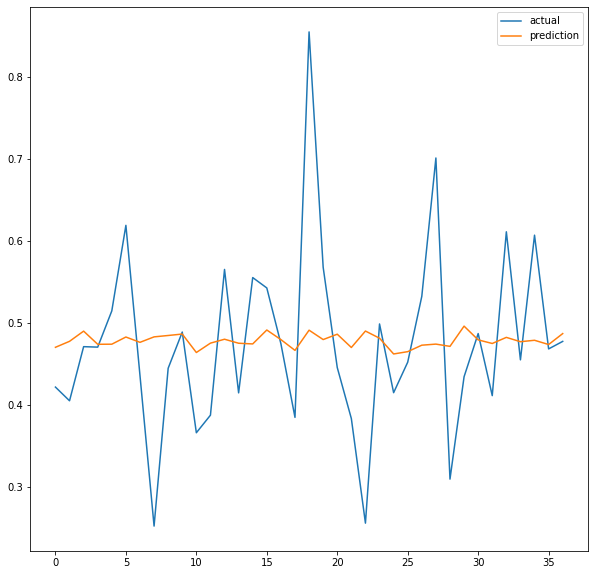

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(actual, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model2 = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 5]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용

loss = Huber()
optimizer = Adam(0.0005)
model2.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [ ]:
# earlystopping은 35번 epoch통안 val_loss 개선이 없다면 학습을 멈춘다 

earlystopping = EarlyStopping(monitor='val_loss', patience=35)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)
                             
history = model2.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=20, 
                    callbacks=[checkpoint, earlystopping])

In [ ]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있다 

# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 5, 4)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32,)


In [ ]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
#filename = os.path.join('tmp', 'ckeckpointer.ckpt')
# checkpoint = ModelCheckpoint(filename, 
#                              save_weights_only=True, 
#                              save_best_only=True, 
#                              monitor='val_loss', 
#                              verbose=1)

In [ ]:
history = model2.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    )#callbacks=[checkpoint, earlystopping])

Epoch 1/50


KeyboardInterrupt: ignored

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt


ValueError: ignored

In [ ]:
pred = model2.predict(test_data)

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


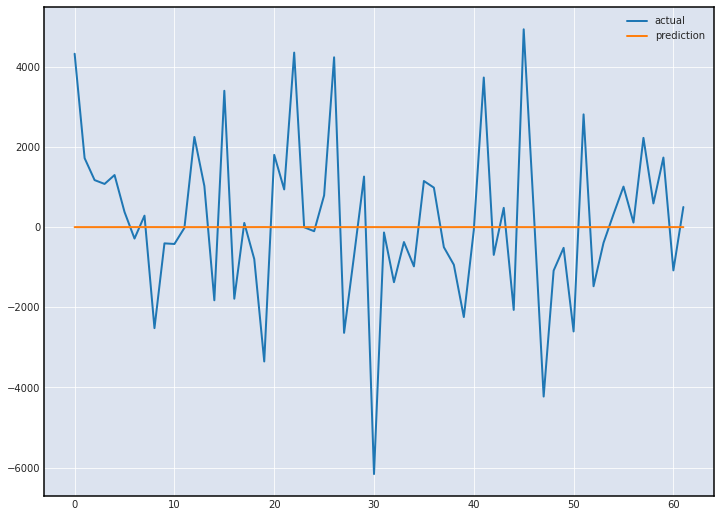

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(Y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [ ]:
X_train.shape

(328, 4)

In [ ]:
#LSTM 모델 생성하기 

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               #input_shape=(100,1), 
               input_shape=(X_train.shape[1], X_train.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(Dense(1))

IndexError: ignored

In [ ]:
# 모델의 학습 

# model.compile(loss='mean_squared_error', optimizer='adam')
# early_stop = EarlyStopping(monitor='val_loss', patience=5)
# #filename = os.path.join(model_path, 'tmp_checkpoint.h5')
# checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

# history = model.fit(X_train, Y_train, 
#                     epochs=10, 
#                     batch_size=16,
#                     validation_data=(X_test, Y_test), 
#                     callbacks=[early_stop, checkpoint])

model.compile(optimizer = 'adam',
              loss= 'mean_squared_error',
              metrics =['accuracy'])

model.fit(X_train, Y_train, epochs=10, batch_size=16)

Epoch 1/10


ValueError: ignored

In [ ]:
# Dividing the Dataset 
feature = ['open', 'high', 'low', 'volume']
label = ['close']

X_train = train[feature]
Y_train = train[label]

# train dataset
#X_train, Y_train = make_dataset(train_feature, train_label, 20)

# train, validation set 생성
from sklearn.model_selection import train_test_split
X_train, _valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

x_train.shape, x_valid.shape
# ((6086, 20, 4), (1522, 20, 4))

# test dataset (실제 예측 해볼 데이터)
test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape
# ((180, 20, 4), (180, 1))

Text(0.5, 1.0, 'test')

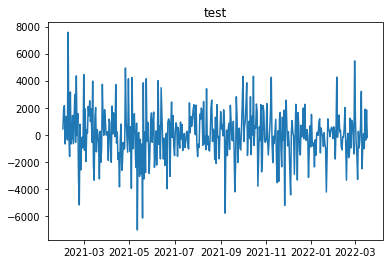

In [ ]:
# 비트코인 가격의 변화량은 Stationary 한가? 
# 작년 11월 ~ 올해 3월 까지의 변화량 

import matplotlib.pyplot as plt
plt.plot(btc_1['index'], btc_1['close'])
plt.title('test')